# Neural Fortran Examples: Sine Wave

## Introduction

In this example, we will train a neural network to approximate the sine function. We will use a simple feedforward neural network with two hidden layers. The network will be trained using the backpropagation algorithm.  The data will be written to a CSV file using the CSV Fortran library https://github.com/jacobwilliams/csv-fortran. The neural network will be implemented in Fortran using the Neural Fortran library https://github.com/modern-fortran/neural-fortran.

Once the data is collected and saved to a CSV file, Pandas and Matplotlib will be used to plot the learned sine wave and mean squared error versus the learning iteration number.

## Neural Network Theory by ChatGPT o1

Below is a concise yet mathematically grounded overview of **dense neural networks**, sometimes referred to as **feedforward** or **fully connected** networks. We will cover their core structure, forward-pass equations, and typical training approach.

---

## Dense Neural Network Structure

A **dense (fully connected) neural network** consists of layers of neurons, where each neuron in one layer connects to **every** neuron in the next layer via a trainable weight. Suppose we have a network with $L$ layers, indexed by $ \ell = 1, 2, \ldots, L$. Each layer $\ell$ has $n_\ell$ neurons. For simplicity, let $\mathbf{x} \in \mathbb{R}^{n_0}$ be the input, where $n_0$ is the input dimension, and let $\mathbf{y} \in \mathbb{R}^{n_L}$ be the network’s output.  

A typical layer $\ell$ of the network (for $1 \le \ell \le L$) is described by a linear transformation followed by an elementwise non-linear activation. Specifically,

$$
  \mathbf{z}^{(\ell)} 
  \;=\; W^{(\ell)}\, \mathbf{h}^{(\ell-1)} \;+\; \mathbf{b}^{(\ell)},
$$

where:
- $W^{(\ell)} \in \mathbb{R}^{n_\ell \times n_{\ell-1}}$ is the weight matrix for layer $\ell$.  
- $\mathbf{b}^{(\ell)} \in \mathbb{R}^{n_\ell}$ is the bias vector.  
- $\mathbf{h}^{(\ell-1)} \in \mathbb{R}^{n_{\ell-1}}$ is the output (also called the activation) of the previous layer ($\ell-1$).  

Next, we apply a (usually nonlinear) activation function $\sigma(\cdot)$ elementwise:

$$
  \mathbf{h}^{(\ell)} 
  \;=\; \sigma\bigl(\mathbf{z}^{(\ell)}\bigr)
  \;=\; 
  \begin{bmatrix}
    \sigma(z_1^{(\ell)}) \\[6pt]
    \sigma(z_2^{(\ell)}) \\[6pt]
    \vdots \\[6pt]
    \sigma(z_{n_\ell}^{(\ell)}) \\[6pt]
  \end{bmatrix}.
$$

For instance, $\sigma$ might be the ReLU function $\max(0, z)$, the sigmoid function $\tfrac{1}{1 + e^{-z}}$, or $\tanh$. The final output layer might also have a special activation (e.g., softmax for classification).

---

## Forward Pass Equations

Using the above notation, we initialize the network’s input as

$$
  \mathbf{h}^{(0)} \;=\; \mathbf{x}.
$$

Then for each layer $\ell = 1, 2, \ldots, L$, we compute

$$
  \mathbf{z}^{(\ell)} = W^{(\ell)}\, \mathbf{h}^{(\ell-1)} + \mathbf{b}^{(\ell)}, 
  \quad
  \mathbf{h}^{(\ell)} = \sigma\bigl(\mathbf{z}^{(\ell)}\bigr).
$$

At the final layer, $\mathbf{h}^{(L)}$ becomes the network’s output $\mathbf{y}$. Hence, a forward pass through a dense network is just iterating these matrix-vector multiplications and elementwise activations.

---

## Training With Gradient Descent

To train the network, we typically have a dataset of inputs $\{\mathbf{x}_i\}$ and corresponding targets $\{\mathbf{t}_i\}$. We define a **loss function** $\mathcal{L}$, such as mean squared error (for regression) or cross-entropy (for classification). For a single training example $(\mathbf{x}, \mathbf{t})$, we might write

$$
  \mathcal{L}(\mathbf{t}, \mathbf{y}) 
  \;=\; \frac{1}{2} \|\mathbf{y} - \mathbf{t}\|^2
  \quad\text{(for an example squared error case).}
$$

The **backpropagation** algorithm computes partial derivatives of $\mathcal{L}$ with respect to each network parameter $\{W^{(\ell)}, \mathbf{b}^{(\ell)}\}$. Gradient-based optimizers (e.g., stochastic gradient descent) then update the parameters in the direction that reduces the loss:

$$
  W^{(\ell)} \;\leftarrow\; W^{(\ell)} \;-\; \eta \,\frac{\partial \mathcal{L}}{\partial W^{(\ell)}}
  \quad,\quad
  \mathbf{b}^{(\ell)} \;\leftarrow\; \mathbf{b}^{(\ell)} \;-\; \eta \,\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(\ell)}},
$$

where $\eta$ is the learning rate. Repeated over many iterations (epochs), the network learns weights that (hopefully) minimize the loss on the training set and generalize to unseen data.

---

This dense architecture is the foundational design for many neural networks. While modern advances (like convolutional or transformer layers) may structure connections differently, the core linear+activation principle remains central to deep learning.

## Code Analysis by ChatGTP o1

Below is a detailed walkthrough of how the **`program sine`** works, focusing on what each block of code accomplishes and how it fits into the overall workflow of training a sine-wave–inspired neural network. We will cover:

1. **Imports and Declarations**  
2. **CSV Logging Initialization**  
3. **Creating Test Data**  
4. **Defining the Neural Network**  
5. **Training Loop** (Forward & Backward passes, updating weights)  
6. **Computing Mean Squared Error**  
7. **Logging Data to CSV**  

Throughout, note that the network code comes from a library `nf` (with `dense`, `input`, `network`, `sgd`), and CSV output is handled by `csv_module`. The code also uses single-precision real numbers (`real32`) for training variables and a double-precision `pi` in some places.

---

## 1. **Imports and Declarations**

```fortran
program sine
  use csv_module
  use nf, only: dense, input, network, sgd
  use iso_fortran_env, only: real32

  implicit none

  real, parameter :: pi = 4 * atan(1.)
```

1. **`csv_module`**: A module that provides CSV reading/writing functionality.  
2. **`nf`**: A custom or third-party neural network framework that exposes:
   - `dense`: A fully connected (dense) layer constructor.
   - `input`: An input layer constructor.
   - `network`: A type or class that composes layers and provides `forward`, `backward`, `update`, `predict`.
   - `sgd`: A function or type for the Stochastic Gradient Descent optimizer.
3. **`iso_fortran_env, only: real32`**: Imports the `real32` kind for single-precision floats (32-bit).  
4. **`implicit none`**: Requires explicit declarations for all variables.  
5. **`pi`**: Defined via `4 * atan(1.)`, which yields $\pi \approx 3.14159265...$.

---

## 2. **CSV Logging Initialization**

```fortran
  type(csv_file) :: sine_NN_data_file
  type(network) :: net

  logical :: status_ok
```

- **`sine_NN_data_file`**: A `csv_file` object that will handle CSV writing.  
- **`net`**: A neural network object.

```fortran
  integer, parameter :: num_iterations = 100000
  integer, parameter :: test_size = 50
  real(kind=real32), parameter :: learning_rate = 0.1
```

- **`num_iterations`**: The number of training iterations (epochs).  
- **`test_size`**: The number of data points for both testing and each training mini-batch (30).  
- **`learning_rate`**: The initial learning rate (0.1) for the `sgd` optimizer.

---

## 3. **Neural Network Dimensions and Data Arrays**

```fortran
  integer, parameter :: num_inputs = 1
  integer, parameter :: num_outputs = 1
  integer, parameter :: num_neurons_first_layer = 10
  integer, parameter :: num_neurons_second_layer = 10
```

- **`num_inputs`**: The network expects 1D input.  
- **`num_outputs`**: The network outputs 1 value.  
- **`num_neurons_first_layer`, `num_neurons_second_layer`**: Two hidden layers with 10 neurons each.

```fortran
  real(kind=real32), dimension(test_size) :: x_test, y_test, x_train, y_train, y_pred
  real, dimension(1) :: x_train_arr_temp
  real, dimension(1) :: y_train_arr_temp
  real, dimension(1) :: x_test_arr_temp
  real, dimension(1) :: y_pred_arr_temp
```

1. **`x_test, y_test`**: Arrays of size `test_size` to store the input and target for the sine wave *test set*.  
2. **`x_train, y_train`**: Arrays of size `test_size` for the random training mini-batch each iteration.  
3. **`y_pred`**: Predictions made on the test data, also size `test_size`.  
4. **`x_train_arr_temp, y_train_arr_temp, x_test_arr_temp, y_pred_arr_temp`**: All `dimension(1)`.  
   - These hold **single-sample** data for the neural network calls. The library expects arrays, even for single-value input. 
   - For instance, `x_train(j)` is stored in `x_train_arr_temp(1)` before calling `forward`.

```fortran
  real(kind=real32), dimension(num_iterations) :: mean_squared_error
  integer :: i, j

  real(kind=real32) :: x_train_temp
```

- **`mean_squared_error`**: An array storing MSE for each of the `num_iterations`.  
- **`x_train_temp`**: A random value used to generate the training data.  

---

### 3.1 **CSV File Initialization**

```fortran
  call sine_NN_data_file%initialize(verbose=.true.)
  ...
  call sine_NN_data_file%open('sine_NN_data.csv', n_cols=7, status_ok=status_ok)
  if (.not. status_ok) then
    ...
  end if
  ...
  call sine_NN_data_file%add(['Iteration', 'x_test___', 'y_test___', &
                              'x_train__', 'y_train__', 'y_pred___', 'MSE______'])
  call sine_NN_data_file%next_row()
```

1. **`initialize`**: Prepares the CSV object.  
2. **`open`**: Opens a file named `sine_NN_data.csv`. The code also specifies `n_cols=7`, meaning each row will eventually have up to 7 columns.  
3. **Header**: `add([...])` writes a header row with column labels, then `next_row()` finalizes that line.

---

## 4. **Creating Test Data**

```fortran
  x_test = [((j - 1) * 2.0d0 * pi / test_size, j = 1, test_size)]
  y_test = (sin(x_test) + 1.0d0) / 2.0d0
```

- For each `j` in `[1..test_size]`, compute $\displaystyle x\_test(j) = \frac{(j - 1)\times 2\pi}{\text{test\_size}}$.  
  - This distributes 30 points evenly between `0` and `2π`.  
- The target is `y_test(j) = (sin(x_test(j)) + 1) / 2`, mapping the sine wave from `[-1, +1]` to `[0, 1]`.

---

## 5. **Constructing the Neural Network**

```fortran
  net = network([ &
    input(num_inputs), &
    dense(num_neurons_first_layer), &
    dense(num_neurons_second_layer), &
    dense(num_outputs) &
  ])
```

- **`network([...])`**: Creates a layered neural network object with the following sequence:
  1. **`input(num_inputs)`**: 1D input layer.  
  2. **`dense(num_neurons_first_layer)`**: A fully connected layer with 10 neurons.  
  3. **`dense(num_neurons_second_layer)`**: Another hidden layer with 10 neurons.  
  4. **`dense(num_outputs)`**: Final layer that outputs a single value.  

```fortran
  call net % print_info()
```

- Prints summary info about the network (number of parameters, layer shapes, etc.).

---

## 6. **Training Loop**

```fortran
  do i = 1, num_iterations
```

A loop over the total epochs (`num_iterations` = 100,000). Each iteration does:

### 6.1 **Mini-Batch Data Generation**

```fortran
    do j = 1, test_size
      call random_number(x_train_temp)
      x_train(j) = x_train_temp * 2.0d0 * pi
      y_train(j) = (sin(x_train(j)) + 1.0d0) / 2.0d0
```

- For each of the `test_size` samples in the batch:  
  1. Generate a random number `x_train_temp` in [0, 1).  
  2. Scale it to `[0, 2π]`.  
  3. Compute `y_train(j)` as `(sin(x_train(j)) + 1.0)/2.0`, so the sine wave is in [0, 1].

### 6.2 **Per-Sample Forward/Backward**

```fortran
      x_train_arr_temp = x_train(j)
      y_train_arr_temp = y_train(j)

      call net % forward(x_train_arr_temp)
      call net % backward(y_train_arr_temp)
      call net % update(optimizer=sgd(learning_rate=learning_rate))
```

- **`x_train_arr_temp`** and **`y_train_arr_temp`** are 1-element arrays. Some neural net frameworks require arrays even for single-value inputs.  
- **`forward(...)`** passes the single sample through the network, producing internal activations.  
- **`backward(...)`** uses the single-sample label `y_train_arr_temp` to compute gradients (loss derivative w.r.t. weights).  
- **`update(...)`** applies **Stochastic Gradient Descent** with `learning_rate=0.1` to update network weights.  

**Important**: This code does a per-sample update inside the loop over `j`. This is effectively “online” or “sample-by-sample” training, repeated `test_size` times per iteration.

### 6.3 **Prediction on the Test Sample**

```fortran
      x_test_arr_temp = x_test(j)
      y_pred_arr_temp = net % predict(x_test_arr_temp)
      y_pred(j) = y_pred_arr_temp(1)
    end do
```

- Takes the test input `x_test(j)`, passes it through the network to get `y_pred_arr_temp` (again a 1-element array).  
- Store `y_pred(j) = y_pred_arr_temp(1)`.

After this inner loop, we have:
- A mini-batch of `test_size` random training samples used for weight updates.
- **`y_pred`** for each of the 30 test points in `x_test`.

---

### 6.4 **Compute Mean Squared Error**

```fortran
    mean_squared_error(i) = sum((y_pred - y_test)**2) / test_size
```

- Compare the network’s predictions `y_pred` with the true test values `y_test`.  
- The MSE for iteration `i` is the average of squared differences.

---

### 6.5 **Logging Each Sample to CSV**

```fortran
    do j = 1, test_size
      call sine_NN_data_file%add([i], int_fmt='(i6)')
      call sine_NN_data_file%add([ &
        x_test(j), & 
        y_test(j), &
        x_train(j), &
        y_train(j), &
        y_pred(j), &
        mean_squared_error(i)], &
        real_fmt='(f9.6)')
      call sine_NN_data_file%next_row()
    end do
```

- We output **50 rows** per iteration. Each row records:
  1. **Iteration** number `i`.
  2. **`x_test(j)`**: The j-th test input.  
  3. **`y_test(j)`**: The sine wave’s true value at `x_test(j)`.  
  4. **`x_train(j)`**: The j-th random training sample.  
  5. **`y_train(j)`**: The training label for that sample.  
  6. **`y_pred(j)`**: The network’s prediction for `x_test(j)`.  
  7. **`mean_squared_error(i)`**: The iteration’s MSE.

Hence, each iteration appends 50 lines to the CSV file, for a total of: $50 \times \{num\_{iterations}\}$ lines.

---

### 6.6 **Occasional Print of MSE**

```fortran
    if (mod(i, (num_iterations/10)) == 0) then
      print '("Iteration: ", I6, " | MSE: ", F9.6)', i, mean_squared_error(i)
    end if
```

- Every 1/10th of `num_iterations` (in this case, every 10000 iterations if `num_iterations=100000`), print the iteration number and current MSE to the console.

---

## 7. **Closing Steps**

```fortran
  print *, '[*] Training complete!'
  print *, '[*] Saving data to the CSV file...'
  ...
  call sine_NN_data_file%close(status_ok=status_ok)
  if (.not. status_ok) then
    print *, '[!] Error closing the CSV file...'
    stop
  end if
end program sine
```

- Signals the end of training and closes the CSV file, ensuring everything is written to disk properly.

---

## 8. **Summary of the Workflow**

1. **Initialize**: Creates a CSV object, sets up the neural network, and preps hyperparameters.  
2. **Generate** a small, fixed test set (`x_test, y_test`) spanning 0 to $2\pi$.  
3. **Create** the network with 1 input neuron, two hidden layers of 10 each, and 1 output.  
4. **Training** (outer loop over `i`):
   - Build a random mini-batch of `test_size` samples (`x_train, y_train`).  
   - For each sample:
     - Convert the single value to a 1-element array, do `forward/backward/update`.  
     - Predict on the corresponding test sample `x_test(j)`.  
   - Compute MSE over all 50 test points.  
   - Write iteration data (50 rows) into a CSV file.  
   - Occasionally print progress.  
5. **Finish**: Print completion message, close the CSV file.

**Key Observations**:
- The code mixes “training data” that’s random each iteration with a fixed “test set” (`x_test`). This is somewhat unusual—often you keep a consistent training set or you randomize from a larger pool. But it works here as a demonstration of incremental training for the sine function.  
- The network is updated on a per-sample basis, repeated 50 times per iteration. That’s effectively a “mini-batch” of size 1 repeated 50 times.  
- The final CSV ends up quite large: `num_iterations × test_size` lines, with 7 columns each.

This design shows how to integrate data generation, single-sample training steps, and CSV logging within a single Fortran program using a custom `network` library.

## Program Code

### section_examples_sine_wave.f90

```{literalinclude} Fortran_Code/Section_Examples_Sine_Wave/app/section_examples_sine_wave.f90
---
language: fortran
---
```

The above program is compiled and run using Fortran Package Manager (fpm).  The following FPM configuration file (fpm.toml) was used:

```{literalinclude} Fortran_Code/Section_Examples_Sine_Wave/fpm.toml
---
language: toml
---
```

## Build the Program using FPM (Fortran Package Manager)

In [1]:
import os
root_dir = ""
root_dir = os.getcwd()

In [2]:
code_dir = root_dir + "/" + "Fortran_Code/Section_Examples_Sine_Wave"

In [3]:
os.chdir(code_dir)

In [4]:
build_status = os.system("fpm build 2>/dev/null")

 + mkdir -p build/dependencies
Initialized empty Git repository in /home/ubuntu/Engineering/MKDynamics_Website_V2/Sections/Computer_Programming/Fortran/Neural_Fortran/Fortran_Code/Section_Examples_Sine_Wave/build/dependencies/csv-fortran/.git/
Initialized empty Git repository in /home/ubuntu/Engineering/MKDynamics_Website_V2/Sections/Computer_Programming/Fortran/Neural_Fortran/Fortran_Code/Section_Examples_Sine_Wave/build/dependencies/neural-fortran/.git/
[  0%]                  csv_kinds.f90
[  1%]                  csv_kinds.f90  done.
[  1%]                 nf_metrics.f90
[  3%]                 nf_metrics.f90  done.
[  3%]              nf_base_layer.f90
[  4%]              nf_base_layer.f90  done.
[  4%]                nf_datasets.f90
[  6%]                nf_datasets.f90  done.
[  6%]          nf_datasets_mnist.f90
[  7%]          nf_datasets_mnist.f90  done.
[  7%]              nf_optimizers.f90
[  9%]              nf_optimizers.f90  done.
[  9%]              nf_activation.f90
[ 10

## Run the Program using FPM (Fortran Package Manager)

The program is run and the output is saved into a file named sine_NN_data.dat

In [5]:
exec_status = \
    os.system("fpm run 2>/dev/null")

 [*] Opening the CSV file...
 [*] Adding header to the CSV file...
[*] Creating Sine Wave Testing Data
 [*] Creating the Neural Network...
Layer: input
------------------------------------------------------------
Output shape: 1
Parameters: 0

Layer: dense
------------------------------------------------------------
Input shape: 1
Output shape: 10
Parameters: 20
Activation: sigmoid

Layer: dense
------------------------------------------------------------
Input shape: 10
Output shape: 10
Parameters: 110
Activation: sigmoid

Layer: dense
------------------------------------------------------------
Input shape: 10
Output shape: 1
Parameters: 11
Activation: sigmoid


 [*] Training the Neural Network...
Iteration:  10000 | MSE:  0.000847
Iteration:  20000 | MSE:  0.000219
Iteration:  30000 | MSE:  0.000114
Iteration:  40000 | MSE:  0.000098
Iteration:  50000 | MSE:  0.000086
Iteration:  60000 | MSE:  0.000071
Iteration:  70000 | MSE:  0.000064
Iteration:  80000 | MSE:  0.000058
Iteration: 

## Plot the Neural Network Predictions and Mean Squared Error

### Read the Data from the CSV File

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
csv_file = "sine_NN_data.csv"
df = pd.read_csv(csv_file, header=0, names=[
        "Iteration", "x_test", "y_test", "x_train", "y_train", "y_pred", "MSE"
    ])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Iteration  int64  
 1   x_test     float64
 2   y_test     float64
 3   x_train    float64
 4   y_train    float64
 5   y_pred     float64
 6   MSE        float64
dtypes: float64(6), int64(1)
memory usage: 267.0 MB


### Group and Average the Mean Squared Error by Iteration

In [8]:
grouped = df.groupby("Iteration")
mse_by_iter = grouped["MSE"].mean()
overall_mse = mse_by_iter.mean()
print(f"Overall Mean Squared Error: {overall_mse}")

Overall Mean Squared Error: 0.00104140101


### Plot the Neural Network Predictions vs True Sine Wave

In [9]:
iteration_step = 5000 # Plot every iteration_step iteration
iteration_list = mse_by_iter.index.to_list()
iterations_to_plot = [1] + list(range(iteration_step, iteration_list[-1]+1, iteration_step))

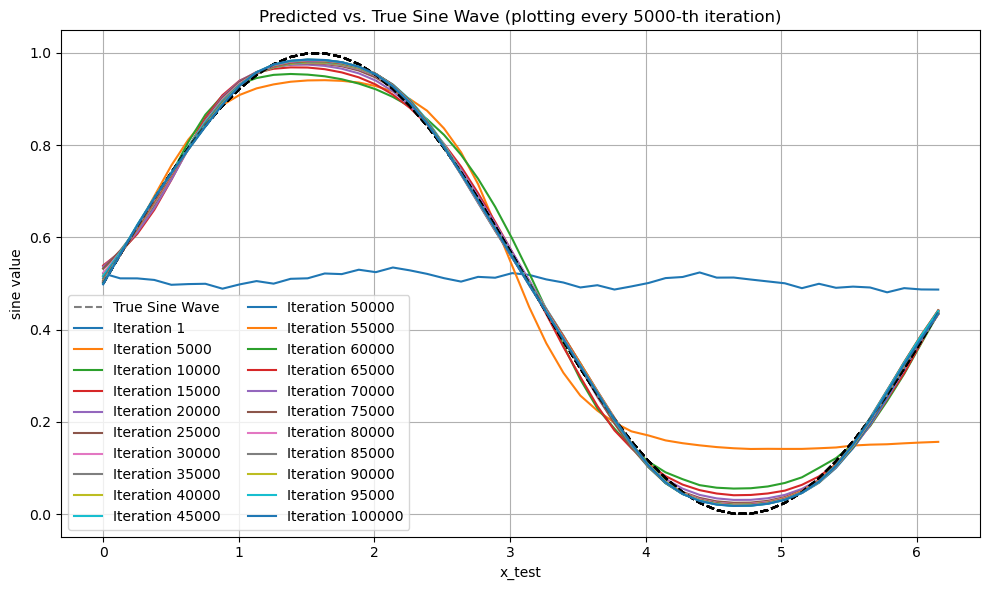

In [10]:
plt.figure(figsize=(10, 6))
for iteration in iterations_to_plot:
    group_df = grouped.get_group(iteration)

    plt.plot(group_df["x_test"], group_df["y_test"], 'k--', alpha=0.5,
                 label="True Sine Wave")
    plt.plot(group_df["x_test"], group_df["y_pred"], label=f"Iteration {iteration}")

plt.xlabel("x_test")
plt.ylabel("sine value")
plt.title(f"Predicted vs. True Sine Wave (plotting every {iteration_step}-th iteration)")
# Avoid repeated legend entries for the 'True Sine' if multiple lines are drawn
handles, labels = plt.gca().get_legend_handles_labels()
# Filter out duplicates by building an ordered dictionary
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", ncol=2)

plt.grid(True)
plt.tight_layout()
plt.show()

### Plot the Mean Squared Error vs Iteration

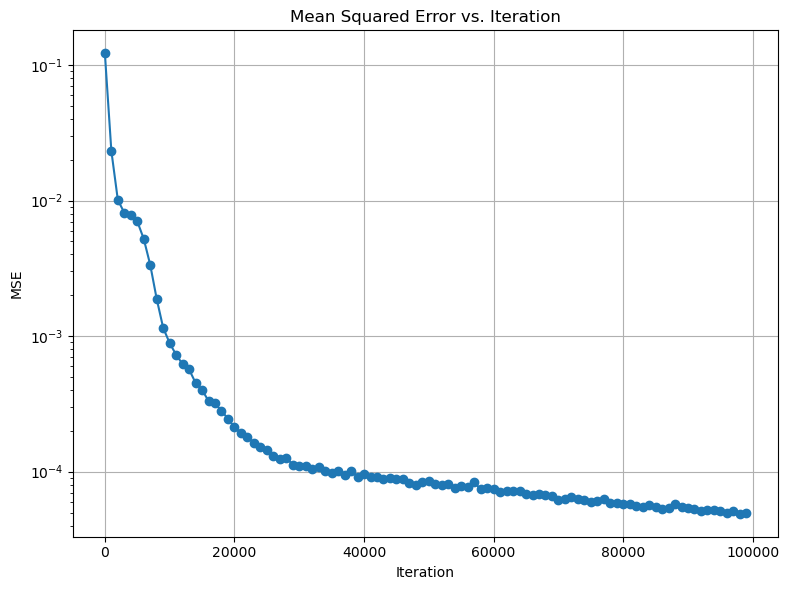

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(mse_by_iter.index[::1000], mse_by_iter.values[::1000], marker='o')
plt.title("Mean Squared Error vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.yscale("log")
plt.show()

## Conclusion

We have successfully trained a neural network to approximate the sine function. The neural network was implemented in Fortran using the Neural Fortran library. The data was written to a CSV file using the CSV Fortran library. The neural network predictions and mean squared error were plotted using Python.

As can be seen from the plot, the neural network was able to approximate the sine function quite well. The mean squared error decreased over time as the neural network was trained. This example demonstrates how neural networks can be used to approximate complex functions such as the sine function.

As the iteration number reached 100,000, the neural network predictions closely matched the true sine wave function. The mean squared error decreased over time as the neural network was trained. This example demonstrates how neural networks can be used to approximate complex functions such as the sine function.

A great improvement on this code would be to implement the training loop using OpenMP.  This would allow the training loop to be parallelized and run on multiple cores.